### Importar bibliotecas

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os

import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt
from statsmodels.tools.eval_measures import mse
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, max_error, mean_absolute_error

### Carregar dados

In [2]:
# Carregar dados do CPU
machine = 'm_103.csv'
workload = pd.read_csv(machine, 
             names = ['machine_id', 'time_stamp', 'cpu', 'mem', 'mem_gps', 
                      'mkpi', 'net_in', 'net_out', 'disk_io_percent'])
workload.time_stamp = pd.to_datetime(workload.time_stamp, unit='s')
workload.set_index('time_stamp', inplace=True)
workload = workload.resample('5min').interpolate()
workload = workload[-12*24*3:] # 5min * 12 * 24 * 3 = 3 days
workload

,machine_id,cpu,mem,mem_gps,mkpi,net_in,net_out,disk_io_percent
time_stamp,,,,,,,,
1970-01-06 00:00:00,m_103,17.0,95.0,NaN,NaN,41.43,29.40,2.0
1970-01-06 00:05:00,m_103,15.0,95.0,NaN,NaN,41.43,29.40,1.0
1970-01-06 00:10:00,m_103,26.0,95.0,NaN,NaN,41.43,29.40,2.0
1970-01-06 00:15:00,m_103,14.0,90.0,NaN,NaN,41.44,29.41,4.0
1970-01-06 00:20:00,m_103,21.0,93.0,NaN,NaN,41.44,29.41,3.0
...,...,...,...,...,...,...,...,...
1970-01-08 23:35:00,m_103,14.0,88.0,2.02,1.0,45.88,32.63,2.0
1970-01-08 23:40:00,m_103,16.0,89.0,1.90,0.0,45.88,32.63,2.0
1970-01-08 23:45:00,m_103,12.0,88.0,1.28,0.0,45.89,32.63,2.0


<AxesSubplot:xlabel='time_stamp'>

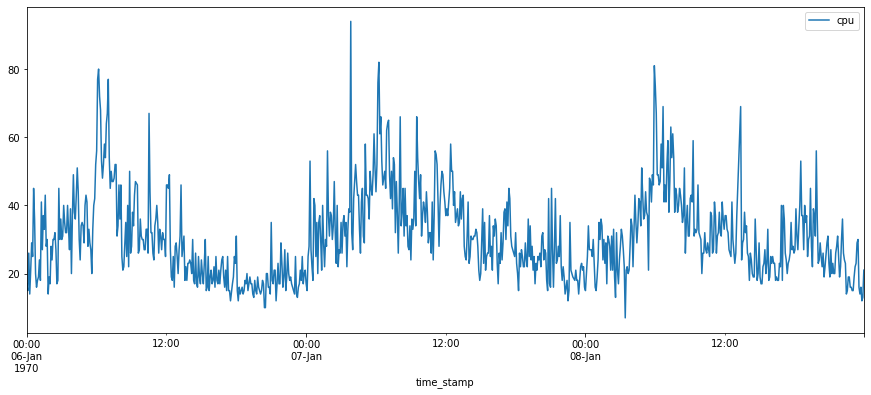

In [3]:
workload[['cpu']].plot(figsize=(15,6))

###  Separar treino e teste

In [4]:
# Separar conjunto de treino e de teste dos dadas de CPU
test_perc = 1/3
test_len = int(len(workload)*test_perc)
str_test_perc = f'{test_len/len(workload):0.2f}'
train_set = workload.cpu[:-test_len]
test_set = workload.cpu[-test_len:]

### Modelo ARIMA

In [5]:
# modelo ARIMA
order=(1,0,0)
model_train = ARIMA(train_set, order=order).fit()
model_test = ARIMA(test_set, order=order).fit(model_train.params)
model_test.params

const     30.862580
ar.L1      0.697743
sigma2    70.022025
dtype: float64

### Seleção dos melhores parâmetros
O método ARIMA(p,d,q) recebe 3 parâmetros que representam:
- p: componente autoregressivo
- d: diferença (usado quando a série não é estacionária)
- q: componente de média móvel

O script abaixo cria diversos modelos, com parâmetors distintos e apresenta ao final a melhor ordem (conjunto de parâmetros) do modelo que obteve o menor erro

In [6]:
# define alguns valores limites a serem testados 
# neste caso a diferença (d) será zero, pois a série é estacionária
max_p, max_d, max_q = 5, 0, 5

# cria uma lista com todas as combinações possíveis destes parâmetros, observando os limites definidos acima
orders = []
for p in range(max_p+1):
    for d in range(max_d+1):
        for q in range(max_q+1):
            orders.append((p,d,q))

# valida cada modelo
errors = []
for order in orders:
    # faz previsões
    X = [x for x in train_set]
    predictions = list()
    for i in range(len(test_set)):
        model = ARIMA(X, order=order, enforce_stationarity=False)
        model_fit = model.fit()
        predict = model_fit.forecast()[0]
        predictions.append(predict)
        X.append(test_set[i])
        
    # guarda os erros de cada previsão em uma lista
    error = np.sqrt(mean_squared_error(test_set, predictions))
    errors.append(error)
    print(order, error, end = ' | ')

# identifica a melhor ordem (p,d,q) que apresentou o menor erro
best_order = None
for order, error in zip(orders, errors):
    best_error = min(errors)
    best_order = order if error == best_error else best_order
print(f'\n\nMelhor resultado:\n\tordem: {best_order}\n\terro: {best_error}')

(0, 0, 0) 11.677563682001837 | (0, 0, 1) 9.571850766539095 | (0, 0, 2) 8.979581003004904 | (0, 0, 3) 8.729355583432673 | (0, 0, 4) 8.576589759484511 | (0, 0, 5) 8.438479076724779 | (1, 0, 0) 8.363109133758599 | (1, 0, 1) 8.062125778594929 | (1, 0, 2) 7.941900051366159 | (1, 0, 3) 7.936883607738654 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


(1, 0, 4) 7.952483975179487 | (1, 0, 5) 7.9608636338074845 | (2, 0, 0) 8.196228425928123 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


(2, 0, 1) 7.929483760541454 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(2, 0, 2) 7.9467852903684655 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(2, 0, 3) 7.962572874106612 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(2, 0, 4) 7.950531602637493 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(2, 0, 5) 7.960881345179161 | (3, 0, 0) 8.111053316834715 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


(3, 0, 1) 7.936153975484529 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(3, 0, 2) 7.934662154608348 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(3, 0, 3) 7.94830453448853 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(3, 0, 4) 7.938129983827142 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(3, 0, 5) 7.957121006303449 | (4, 0, 0) 8.067595348481296 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(4, 0, 1) 7.949549378840957 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


(4, 0, 2) 7.949771437434864 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(4, 0, 3) 7.954126287912478 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(4, 0, 4) 7.96527046148879 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(4, 0, 5) 7.985091644602363 | (5, 0, 0) 8.017781995181878 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(5, 0, 1) 7.955098963563326 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(5, 0, 2) 7.973196731468865 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(5, 0, 3) 7.945989954124887 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(5, 0, 4) 7.999316893387479 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(5, 0, 5) 7.9627380476061385 | 

Melhor resultado:
	ordem: (2, 0, 1)
	erro: 7.929483760541454


/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


### Execução do modelo com os melhores parâmetros

In [7]:
# modelo ARIMA
# faz previsões com a melhor ordem
order = best_order
X = [x for x in train_set]
predictions = list()
for i in range(len(test_set)):
    model = ARIMA(X, order=order, enforce_stationarity=False)
    model_fit = model.fit()
    predict = model_fit.forecast()[0]
    predictions.append(predict)
    X.append(test_set[i])

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


### Comparar previsão x teste

In [8]:
results = pd.DataFrame({'Real':test_set, 'Predict':predictions})
results

,Real,Predict
time_stamp,,
1970-01-08 00:00:00,15.0,19.491410
1970-01-08 00:05:00,20.0,18.630242
1970-01-08 00:10:00,25.0,20.196460
1970-01-08 00:15:00,34.0,22.363396
1970-01-08 00:20:00,27.0,26.653521
...,...,...
1970-01-08 23:35:00,14.0,20.860705
1970-01-08 23:40:00,16.0,19.308795
1970-01-08 23:45:00,12.0,19.400607


<AxesSubplot:xlabel='time_stamp'>

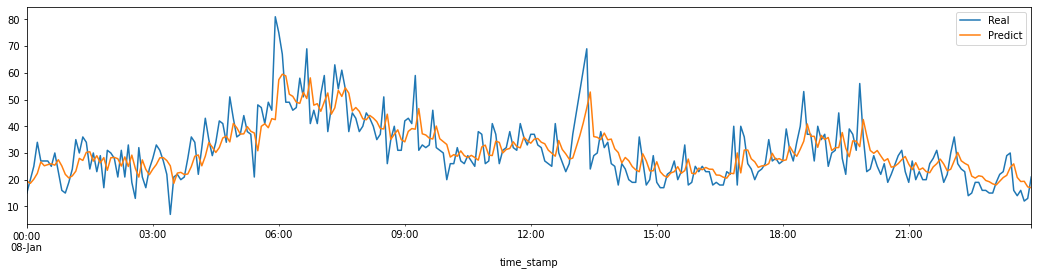

In [9]:
# compara a previsão com o conjunto de teste
results.plot(figsize=(18,4))

### Validação do modelo
Na validação do modelo foi utilizada a técnica do erro quadrático médio, com o método 'mse' da biblioteca statsmodels.
Este método recebe como parâmetro o conjunto de teste e a previsão gerada pelo modelo. O resultado apresentado significa a taxa de erro, quanto menor melhor.

In [10]:
# validate predict with test set
def validate(y_test, pred):
    mse = mean_squared_error(y_test, pred)
    print(f'mean_squared_error: {mse}')
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(f'root_mean_squared_error: {rmse}')
    cd = r2_score(y_test, pred)
    print(f'Determination coeficient: {cd}')
    ev = explained_variance_score(y_test, pred)
    print(f'explained_variance_score: {ev}')
    me = max_error(y_test, pred)
    print(f'max_error: {me}')
    mae = mean_absolute_error(y_test, pred)
    print(f'mean_absolute_error: {mae}')
validate(test_set, predictions)

mean_squared_error: 62.87671270869065
root_mean_squared_error: 7.929483760541454
Determination coeficient: 0.5382429624411675
explained_variance_score: 0.5382866328455129
max_error: 38.52598279026832
mean_absolute_error: 5.952091315134104
